<a href="https://colab.research.google.com/github/Doesjka/TM10007_ML_g9/blob/PCA/Kopie_van_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment template

In [61]:
# Run this to use from colab environment
!git clone https://github.com/Doesjka/TM10007_ML_g9.git

fatal: destination path 'TM10007_ML_g9' already exists and is not an empty directory.


## Import packages

In [62]:
import os
import pandas as pd
import numpy as np
from numpy import array

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import decomposition
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score, recall_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.utils.fixes import loguniform
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold

import seaborn
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import randint
import warnings

# Functions for plotting ROC curve
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Define functions

## Data loading

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [63]:
def load_data():
    data = pd.read_csv('/content/TM10007_ML_g9/worclipo/Lipo_radiomicFeatures.csv', index_col=0)
    print(f'The number of features: {len(data.columns)}')
    print(f'The number of samples: {len(data.index)}')
    data_punten = len(data.index) * len(data.columns)
    ls = (data['label'] == 'liposarcoma').sum()
    print(f'Of these samples {ls} are liposarcomas. That is {round(ls/len(data.index)*100)} percent.')
    return data

## Splitting data in train and test set


In [64]:
def extract_labels(data):
    y = data['label']

    lb = preprocessing.LabelBinarizer()
    y = lb.fit_transform(y)
    y = y.flatten()

    X = data.drop('label', axis=1)
    return X, y

In [65]:
def split1(data):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test

## Normaal verdeling en Variantie

### Normaal verdeling
Hieronder berekenen we hoe veel van de features normaal verdeeld zijn

In [66]:
def normaal_verdeeld(X_train):
    aantal_normaal = 0

    for column in X_train.columns:
        result = stats.shapiro(X_train[column])
        normaal = result.pvalue > 0.05
        aantal_normaal += normaal

    print(aantal_normaal, " features have a normal distribution.")
    print("")

### Variantie

In [67]:
def variantie(X_train):
    variantie = X_train.var(axis=0)
    variantie = variantie.sort_values()
    # Haal features met variantie van 0 eruit, want die zeggen dus helemaal niks
    zero_variance = variantie.keys()[variantie==0]
    X_train = X_train.drop(zero_variance, axis=1)
    print(f"{len(zero_variance)} features have a variance of zero. These features are deleted.")
    print("")
    return X_train, zero_variance

## Handling missing data 

### Throwing out features
All features that exist of at least 50% zeros are deleted from the data. 

In [68]:
def zeros_features(X_train):
    zeros = (X_train == 0).sum()
    threshold = 0.5 * len(y_train)
    feature_del = zeros[zeros > threshold]

    X_train_new = X_train.drop(columns=feature_del.index)
    print(f'For {len(X_train.columns)-len(X_train_new.columns)} features the data consisted of more than 50% zeros. These features are deleted.')

    more_zeros = (X_train_new == 0).sum()
    columns_zeros = more_zeros[more_zeros > 0].index
    print(f'Of the remaining features, {len(columns_zeros)} features have at least one zero')
    print(f'There is a total of {more_zeros.sum()} zeros left in the data')
    print("")

    return X_train_new, feature_del

### Calculate number of missing values per sample

In [69]:
def zeros_samples(X_train):
    zeros_r = (X_train == 0).sum(axis=1)
    threshold = 0.5 * X_train.size / len(y_train)
    sample_del = zeros_r[zeros_r > threshold]
    X_train_new = X_train.drop(index=sample_del.index)

    print(f'For {len(X_train.index)-len(X_train_new.index)} samples the data consisted of more than 50% zeros. These samples are deleted.')
    more_zeros = (X_train_new == 0).sum()
    print(f'There is a total of {more_zeros.sum()} zeros left in the data')
    print("")
    return X_train_new

### Filling remaining zeros
All remaining zeros are replaced by the median of that feature. 

In [70]:
def fill_zeros_median(X_train):
    more_zeros = (X_train == 0).sum()
    columns_zeros = more_zeros[more_zeros > 0].index

    for column in columns_zeros[:]:
        column_median = X_train.loc[X_train[column]!=0, column].median()
        X_train[column].replace(0, column_median)
        
    return X_train

def fill_zeros_mean(X_train):
    more_zeros = (X_train == 0).sum()
    columns_zeros = more_zeros[more_zeros > 0].index

    for column in columns_zeros[:]:
        column_mean = X_train.loc[X_train[column]!=0, column].mean()
        X_train[column].replace(0, column_mean)

    return X_train

## Outliers eruit halen


In [71]:
def outliers(X_train):

    outliers_total = 0

    for column in X_train.columns:
        q1 = X_train[column].quantile(0.25)
        q3 = X_train[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)

        outliers_column = (X_train[column] < lower_bound).sum() + (X_train[column] > upper_bound).sum()
        outliers_total += outliers_column

        X_train.loc[X_train[column] < lower_bound, column] = lower_bound
        X_train.loc[X_train[column] > upper_bound, column] = upper_bound

    print(f"{outliers_total} outliers were replaced.")
    print(f"This was {round(outliers_total / (len(data.index) * len(data.columns)) *100)}% of the total amount of datapoints.")
    print("")
    return X_train

## Scaling

In [72]:
def scaling(X_train):
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    
    # scaler = preprocessing.MinMaxScaler().fit(X_train)
    # X_train_scaled = scaler.transform(X_train)
    # X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

    return X_train_scaled_df, scaler



## ANOVA

In [73]:
# ANOVA feature selection for numeric input and categorical output

def anova_feature_selection(X_train_scaled_df):
    fs = SelectKBest(score_func=f_classif, k='all')

    fit = fs.fit(X_train_scaled_df, y_train)
    fit = fit.pvalues_
    df = pd.DataFrame(fit, columns=['P-value'], index=X_train_scaled_df.columns)
    rslt_df = df[df['P-value'] <= 0.1]
    transpose = X_train_scaled_df.transpose()
    new_df= rslt_df.join(transpose, how='left')
    new_df = new_df.transpose()
    X_train_ANOVA = new_df.drop('P-value', axis=0)
    return X_train_ANOVA, rslt_df

## PCA

In [74]:
def principle_components(X_train_ANOVA):
    pca = decomposition.PCA()
    pca.fit(X_train_ANOVA)
    X_pca = pca.transform(X_train_ANOVA)

    component = 0
    total_ratio = 0
    while total_ratio < 0.9:
        total_ratio += pca.explained_variance_ratio_[component]
        component+=1

    component2=0
    grens = 0.0001
    while pca.explained_variance_ratio_[component2] > grens:
        component2+=1

    print("90 procent of the explained variance ratio gives",component, "components. These components we will use from now on.")
    print(f"The last component that contributes more than {grens} to the explained variance is {component2}.")
    print("")
    X_pca = X_pca[:,0:component]
    return X_pca, pca, component


## Create custom scoring

In [75]:
def custom_score(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    score = 2 * accuracy * recall / (accuracy + recall)
    return score

def macro_recall(y_true, y_pred):
    return recall_score(y_true, y_pred, average='macro')

## Linear Classification

In [76]:
def LDA(X_pca,y_train1,clsfs):
    print("Working on the Linear Discriminant Analysis.")
    LDA_classifier = LinearDiscriminantAnalysis()
    LDA_classifier.fit(X_pca, y_train1)
    clsfs.append(LDA_classifier)

    # Define split
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    accuracy_mean = 0
    recall_mean = 0
    harmonic_mean_mean = 0

    for train, test in skf.split(X_pca,y_train1):
        # Splits de data
        X_train = X.iloc[train,:]
        X_val = X.iloc[test,:]
        y_train = y[train]
        y_true = y[test]

        LDA_classifier = LinearDiscriminantAnalysis()
        LDA_classifier.fit(X_train, y_train)

        y_pred = LDA_classifier.predict(X_val)

        accuracy = accuracy_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred, average='macro')
        harmonic_mean = custom_score(y_true, y_pred)


        accuracy_mean += accuracy
        recall_mean += recall
        harmonic_mean_mean += harmonic_mean

    accuracy_mean /= 10
    recall_mean /= 10
    harmonic_mean_mean /= 10
    print("Harmonic mean of LDA is:", harmonic_mean_mean)
    print(f"The mean accuracy score of LDA is {accuracy_mean}")
    print(f"The mean recall score of LDA is {recall_mean}")

    print("")
    return clsfs

## Quadratic Discriminant Analysis

In [77]:
def QDA(X_pca, y_train, clsfs):
    print("Working on the Quadratic Discriminant Analysis.")
    # set parameters
    parameters = {'reg_param': np.arange(0, 1, 0.1)}

    # Specify the cross validation method to use, we use 10-fold stratified cross-validation
    cv_10fold = model_selection.StratifiedKFold(n_splits=10)

    # Create QDA object
    qda = model_selection.RandomizedSearchCV(QuadraticDiscriminantAnalysis(), parameters, n_iter=11,
                                    cv=cv_10fold, scoring=scoring, refit='harmonic_mean', random_state=42)

    # Do the search
    qda.fit(X_pca, y_train)

    # Show the complete results of the cross validation
    qda_df = pd.DataFrame(qda.cv_results_)
    qda_df = qda_df.sort_values(by=['rank_test_harmonic_mean'])
    # display(qda_df)
    print("Best parameters for QDA are: ", qda.best_params_)
    print("Harmonic mean of QDA is:", qda.best_score_)
    print(f"The mean accuracy score of QDA is {qda_df['mean_test_accuracy'].iloc[0]}")
    print(f"The mean recall score of QDA is {qda_df['mean_test_recall'].iloc[0]}")

    # Extract the best hyperparameters and fit
    QDA_classifier = qda.best_estimator_
    QDA_classifier.fit(X_pca, y_train)
    clsfs.append(QDA_classifier)
    print("")
    return clsfs

## k-NN

In [78]:
def KNN(X_pca, y_train, clsfs):
    print("Working on the KNN classification.")
    # Specify the search range, this could be multiple parameters for more complex classifiers
    parameters = {'n_neighbors': randint(1, 10),
                'weights': ['uniform'],
                'p': randint(1, 5),
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                'leaf_size': [2, 4, 10, 30]}

    # Specify the cross validation method to use, we use 10-fold stratified cross-validation
    cv_10fold = model_selection.StratifiedKFold(n_splits=10)

    # Create the grid search method, use area under ROC curve as scoring metric
    # Too learn more about metrics see: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    clf = model_selection.RandomizedSearchCV(neighbors.KNeighborsClassifier(), parameters, cv=cv_10fold, n_iter=500, scoring=scoring, refit='harmonic_mean', random_state=42)

    # Do the entire search
    clf.fit(X_pca, y_train)

    # Show the complete results of the cross validation
    clf_df = pd.DataFrame(clf.cv_results_)
    # print(clf_df)

    # Extract the best k 
    clf_df = clf_df.sort_values(by=['rank_test_harmonic_mean'])
    print("Best parameters for KNN are: ", clf.best_params_)
    print("Harmonic mean of KNN classifier is:", clf.best_score_)
    print(f"The mean accuracy score of KNN classifier is {clf_df['mean_test_accuracy'].iloc[0]}.")
    print(f"The mean recall score of KNN classifier is {clf_df['mean_test_recall'].iloc[0]}.")

    # Extract the best hyperparameters and fit
    knn_classifier = clf.best_estimator_
    knn_classifier.fit(X_pca, y_train)
    clsfs.append(knn_classifier)
    print("")
    return clsfs

## Random Forest

In [79]:
def RF(X_pca, y_train, clsfs):
    print("Working on the Random Forest classification")
    parameters = {'n_estimators': np.arange(50, 400, 50),
                'max_depth': [5, 10, 15],
                'min_samples_leaf': [2, 4]}

    cv_10fold = model_selection.StratifiedKFold(n_splits=10)
    # print(scoring)
    clf = model_selection.RandomizedSearchCV(RandomForestClassifier(), parameters, cv=cv_10fold, n_iter=40, scoring=scoring, refit='harmonic_mean', random_state=42)
        
    # Fit the classifier
    clf.fit(X_pca, y_train)

    # Show the complete results of the cross validation
    clf_df = pd.DataFrame(clf.cv_results_)
    clf_df = clf_df.sort_values(by=['rank_test_harmonic_mean'])

    # Extract the best hyperparameters 
    print("Best parameters for RF are: ", clf.best_params_)
    print("Harmonic mean of random forest classifier is:", clf.best_score_)
    print(f"The mean accuracy score of random forest classifier is {clf_df['mean_test_accuracy'].iloc[0]}")
    print(f"The mean recall score of random forest classifier is {clf_df['mean_test_recall'].iloc[0]}")

    # Extract the best hyperparameters and fit
    RF_classifier = clf.best_estimator_
    RF_classifier.fit(X_pca, y_train)
    clsfs.append(RF_classifier)
    print("")
    return clsfs


## SVM

In [80]:
def SVM(X_pca, y_train, clsfs):
    print("Working on the SVM classification.")

    parameters = {'C': loguniform(0.1, 100),
                'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
                'degree': randint(1, 5),
                'gamma': loguniform(1e-4, 1e-3),
                'class_weight':['balanced', None]}
    
    cv_10fold = model_selection.StratifiedKFold(n_splits=10)

    clf = model_selection.RandomizedSearchCV(SVC(probability=True), parameters, cv=cv_10fold, n_iter=500, scoring=scoring, refit='harmonic_mean',random_state=42)

    # Do the entire search
    clf.fit(X_pca, y_train)

    # Show the complete results of the cross validation
    clf_df = pd.DataFrame(clf.cv_results_)
    clf_df = clf_df.sort_values(by=['rank_test_harmonic_mean'])

    # Extract the best hyperparameters 
    print("Best parameters for SVM are: ", clf.best_params_)
    print("Harmonic mean of SVM classifier is:", clf.best_score_)
    print(f"The mean accuracy score of SVM classifier is {clf_df['mean_test_accuracy'].iloc[0]}")
    print(f"The mean recall score of SVM classifier is {clf_df['mean_test_recall'].iloc[0]}")

    # Extract the best hyperparameters and fit
    svm_classifier = clf.best_estimator_
    svm_classifier.fit(X_pca, y_train)
    clsfs.append(svm_classifier)
    print("")
    return clsfs

## Learning curves

In [81]:
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Number of training samples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        model_selection.learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, random_state=42)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

def plot_all_curves(X_train):
    fig = plt.figure(figsize=(24,10))
    num = 0
    for clf in clsfs:
        num +=1
        ax = fig.add_subplot(2, 3, num)
        title = str(type(clf))
        plot_learning_curve(clf, title, X_train, y_train, ax, ylim=(0.3, 1.01), cv=10)

## ROC

In [82]:
def plot_roc_curve(y_score, y_truth, plt):
    '''
    Plot an ROC curve.
    '''
    # Only take scores for class = 1
    y_score = y_score[:, 1]
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, thresholds = roc_curve(y_truth, y_score)
    roc_auc = auc(fpr, tpr)

    # Find the index of the threshold value closest to 0.5
    idx = np.abs(thresholds - 0.5).argmin()
    
    # Plot the ROC curve
    # plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.scatter(fpr[idx], tpr[idx], color='black', marker='x')
    

# Pre-processing functions

In [83]:
def pre_processing_train(X_train):
    # Test hoe veel van de features normaal verdeeld zijn.
    # normaal_verdeeld(X_train)

    # Bepaal de variantie en gooi features eruit die een variantie van nul hebben.
    X_train, zero_variance = variantie(X_train)

    # Features en samples met te veel nullen eruit gooien
    X_train, feature_del = zeros_features(X_train)
    X_train = zeros_samples(X_train)

    # Remove outliers
    X_train = outliers(X_train)

    # Scaling
    X_train, scaler = scaling(X_train)

    # Anova feature selection
    X_train, rslt_df = anova_feature_selection(X_train)

    # PCA
    X_train, pca, component = principle_components(X_train)

    return X_train, zero_variance, feature_del, scaler, rslt_df, pca, component

In [84]:
def pre_processing_test(X_test, zero_variance, feature_del, scaler, rslt_df, pca, component):
    # Test hoe veel van de features normaal verdeeld zijn. Enkel informatief.
    normaal_verdeeld(X_test)

    # features die eruit gegooid werden op basis van variantie
    X_test = X_test.drop(zero_variance, axis=1)

    # Features die te veel nullen hadden eruit gooien
    X_test = X_test.drop(columns=feature_del.index)

    # Scaling
    X_test_scaled = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # Anova feature selection
    transpose = X_test.transpose()
    new_df= rslt_df.join(transpose, how='left')
    new_df = new_df.transpose()
    X_test = new_df.drop('P-value', axis=0)

    # PCA
    X_test_pca = pca.transform(X_test)
    X_test = X_test_pca[:,0:component]

    return X_test

# Using the functions

## Kijken welke PCA kernels


The number of features: 494
The number of samples: 115
Of these samples 58 are liposarcomas. That is 50 percent.
21 features have a variance of zero. These features are deleted.

For 10 features the data consisted of more than 50% zeros. These features are deleted.
Of the remaining features, 10 features have at least one zero
There is a total of 44 zeros left in the data

For 0 samples the data consisted of more than 50% zeros. These samples are deleted.
There is a total of 44 zeros left in the data

2037 outliers were replaced.
This was 4% of the total amount of datapoints.

linear  [0.4122779  0.175411   0.07611376 0.04360308 0.02865108]
poly  2   [0.27480183 0.12044159 0.10081313 0.05730542 0.04759545]
poly  3   [0.22356552 0.11559539 0.09022736 0.06833271 0.04115698]
poly  4   [0.19869899 0.13629221 0.08691173 0.07237355 0.03818231]
rbf  [0.11451064 0.08059542 0.07571618 0.03843479 0.03594195]


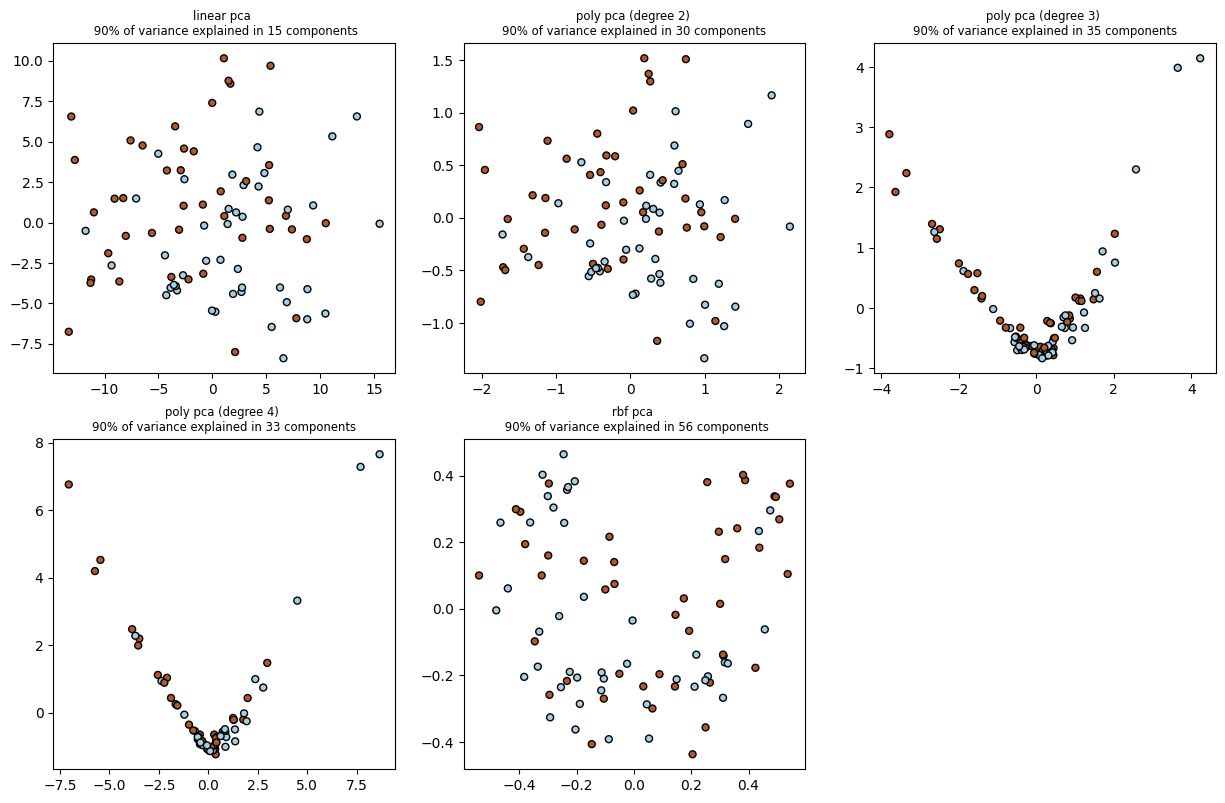

In [85]:
# Load data
data = load_data()

# Split data
X, y = extract_labels(data)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Bepaal de variantie en gooi features eruit die een variantie van nul hebben.
X_train, zero_variance = variantie(X_train)

# Features en samples met te veel nullen eruit gooien
X_train, feature_del = zeros_features(X_train)
X_train = zeros_samples(X_train)

# Remove outliers
X_train = outliers(X_train)

# Scaling
X_train, scaler = scaling(X_train)

# Anova feature selection
X_train, rslt_df = anova_feature_selection(X_train)

kernels = ['linear', 'poly', 'rbf']#, 'sigmoid', 'cosine']#, 'precomputed'] 
degrees = [2, 3, 4]

# Figuur initiëren
fig = plt.figure(figsize=(15,10*len(kernels)))

num=0 
for kernel in kernels:
    if kernel == 'poly':
        for degree in degrees:
            pca = decomposition.KernelPCA(kernel=kernel,degree=degree)
            pca.fit(X_train)
            X_pca = pca.transform(X_train)
            ax = fig.add_subplot(6, 3, num + 1)
            ax.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=y_train,
               s=25, edgecolor='k', cmap=plt.cm.Paired)
            
            # print(kernel + " ", str(degree), " ", pca.eigenvalues_[0:5])
            explained_variance_ratios = pca.eigenvalues_ / pca.eigenvalues_.sum()
            print(kernel + " ", str(degree), " ", explained_variance_ratios[0:5])
            
            total_ratio = 0
            i=0
            while total_ratio < 0.9:
                total_ratio += explained_variance_ratios[i]
                i+=1

            ax.set_title(kernel + " pca (degree " + str(degree) + ") \n" +
                        #  "r5 = " + str(round(explained_variance_ratios[0:4].sum(),3))+ " "  +
                        #  "r10 = " + str(round(explained_variance_ratios[0:9].sum(),3))+ " "  +
                    "90% of variance explained in " + str(i) + " components",
             fontsize='small')
            num+=1
    else:
        pca = decomposition.KernelPCA(kernel=kernel)
        pca.fit(X_train)
        X_pca = pca.transform(X_train)
        ax = fig.add_subplot(6, 3, num + 1)
        ax.scatter(X_pca[:, 0], X_pca[:, 1], marker='o', c=y_train,
               s=25, edgecolor='k', cmap=plt.cm.Paired)
        
        # print(kernel, " ", pca.eigenvalues_[0:5])
        explained_variance_ratios = pca.eigenvalues_ / pca.eigenvalues_.sum()
        print(kernel + " ", explained_variance_ratios[0:5])

        i=0
        total_ratio = 0
        while total_ratio < 0.9:
            total_ratio += explained_variance_ratios[i]
            i+=1

        ax.set_title(kernel + " pca \n " + 
            	    # "r5 = " + str(round(explained_variance_ratios[0:4].sum(),3))+ " "  +
                    # "r10 = " + str(round(explained_variance_ratios[0:9].sum(),3))+ " "  +
                    "90% of variance explained in " + str(i) + " components",
             fontsize='small')

        num+=1


## Training

The number of features: 494
The number of samples: 115
Of these samples 58 are liposarcomas. That is 50 percent.
21 features have a variance of zero. These features are deleted.

For 10 features the data consisted of more than 50% zeros. These features are deleted.
Of the remaining features, 10 features have at least one zero
There is a total of 44 zeros left in the data

For 0 samples the data consisted of more than 50% zeros. These samples are deleted.
There is a total of 44 zeros left in the data

2037 outliers were replaced.
This was 4% of the total amount of datapoints.

90 procent of the explained variance ratio gives 15 components. These components we will use from now on.
The last component that contributes more than 0.0001 to the explained variance is 61.

Working on the Linear Discriminant Analysis.
Harmonic mean of LDA is: 0.6370050268662173
The mean accuracy score of LDA is 0.638888888888889
The mean recall score of LDA is 0.6366666666666666

Working on the Quadratic Discri

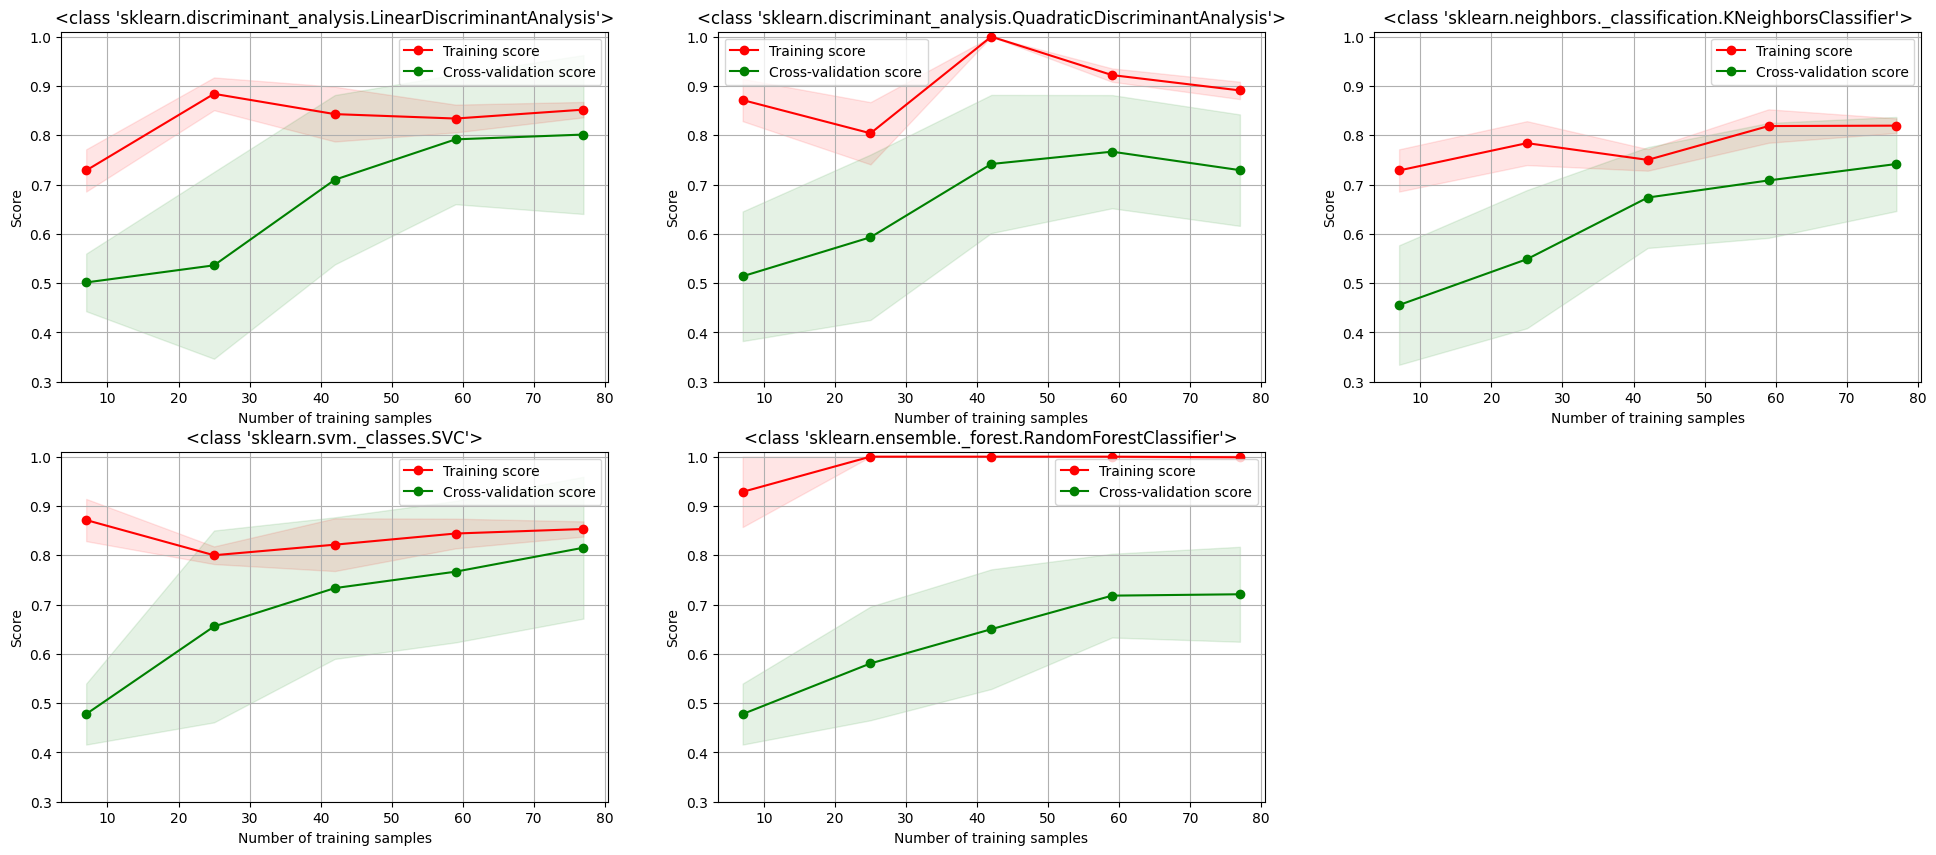

In [86]:
warnings.filterwarnings("ignore")

# Load data
data = load_data()

# Split data
X, y = extract_labels(data)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Pre-processing
X_train, zero_variance, feature_del, scaler, rslt_df, pca, component = pre_processing_train(X_train)

# Initiate classifications
clsfs = list()
# scoring = make_scorer(custom_score)
scoring = {'harmonic_mean': make_scorer(custom_score), 'accuracy': make_scorer(accuracy_score), 'recall': make_scorer(macro_recall)}

# Classifiers
clsfs = LDA(X_train,y_train,clsfs)
clsfs = QDA(X_train,y_train,clsfs)
clsfs = KNN(X_train,y_train,clsfs)
clsfs = SVM(X_train, y_train, clsfs)
clsfs = RF(X_train, y_train, clsfs)

# Plot learning curves
plot_all_curves(X_train)


## Test

176  features have a normal distribution.



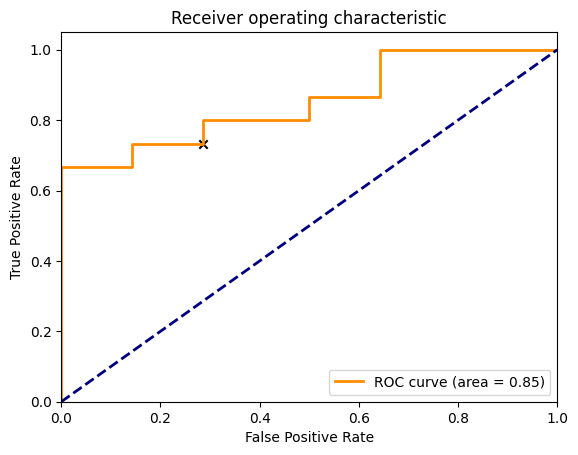

The accuracy is 0.7586206896551724. The recall is 0.7595238095238095. The harmonic mean of the two is 0.7590719809637121.


In [87]:
X_test = pre_processing_test(X_test, zero_variance, feature_del, scaler, rslt_df, pca, component)
clf = clsfs[3]

# ROC
y_score = clf.predict_proba(X_test)
plt.figure()
plot_roc_curve(y_score, y_test, plt)
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Scores berekenen
y_true = y_test
y_pred = clf.predict(X_test)
harmonic = custom_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
recall = macro_recall(y_true, y_pred)
print(f"The accuracy is {accuracy}. The recall is {recall}. The harmonic mean of the two is {harmonic}.")

## Outer cross validatie

The number of features: 494
The number of samples: 115
Of these samples 58 are liposarcomas. That is 50 percent.
-----------------------------------------
Working on fold  1
Pre-processing
19 features have a variance of zero. These features are deleted.

For 10 features the data consisted of more than 50% zeros. These features are deleted.
Of the remaining features, 13 features have at least one zero
There is a total of 97 zeros left in the data

For 0 samples the data consisted of more than 50% zeros. These samples are deleted.
There is a total of 97 zeros left in the data

2214 outliers were replaced.
This was 4% of the total amount of datapoints.

90 procent of the explained variance ratio gives 20 components. These components we will use from now on.
The last component that contributes more than 0.0001 to the explained variance is 84.

Working on the SVM classification.
Best parameters for SVM are:  {'C': 0.21911533674189185, 'class_weight': None, 'degree': 2, 'gamma': 0.0003313658

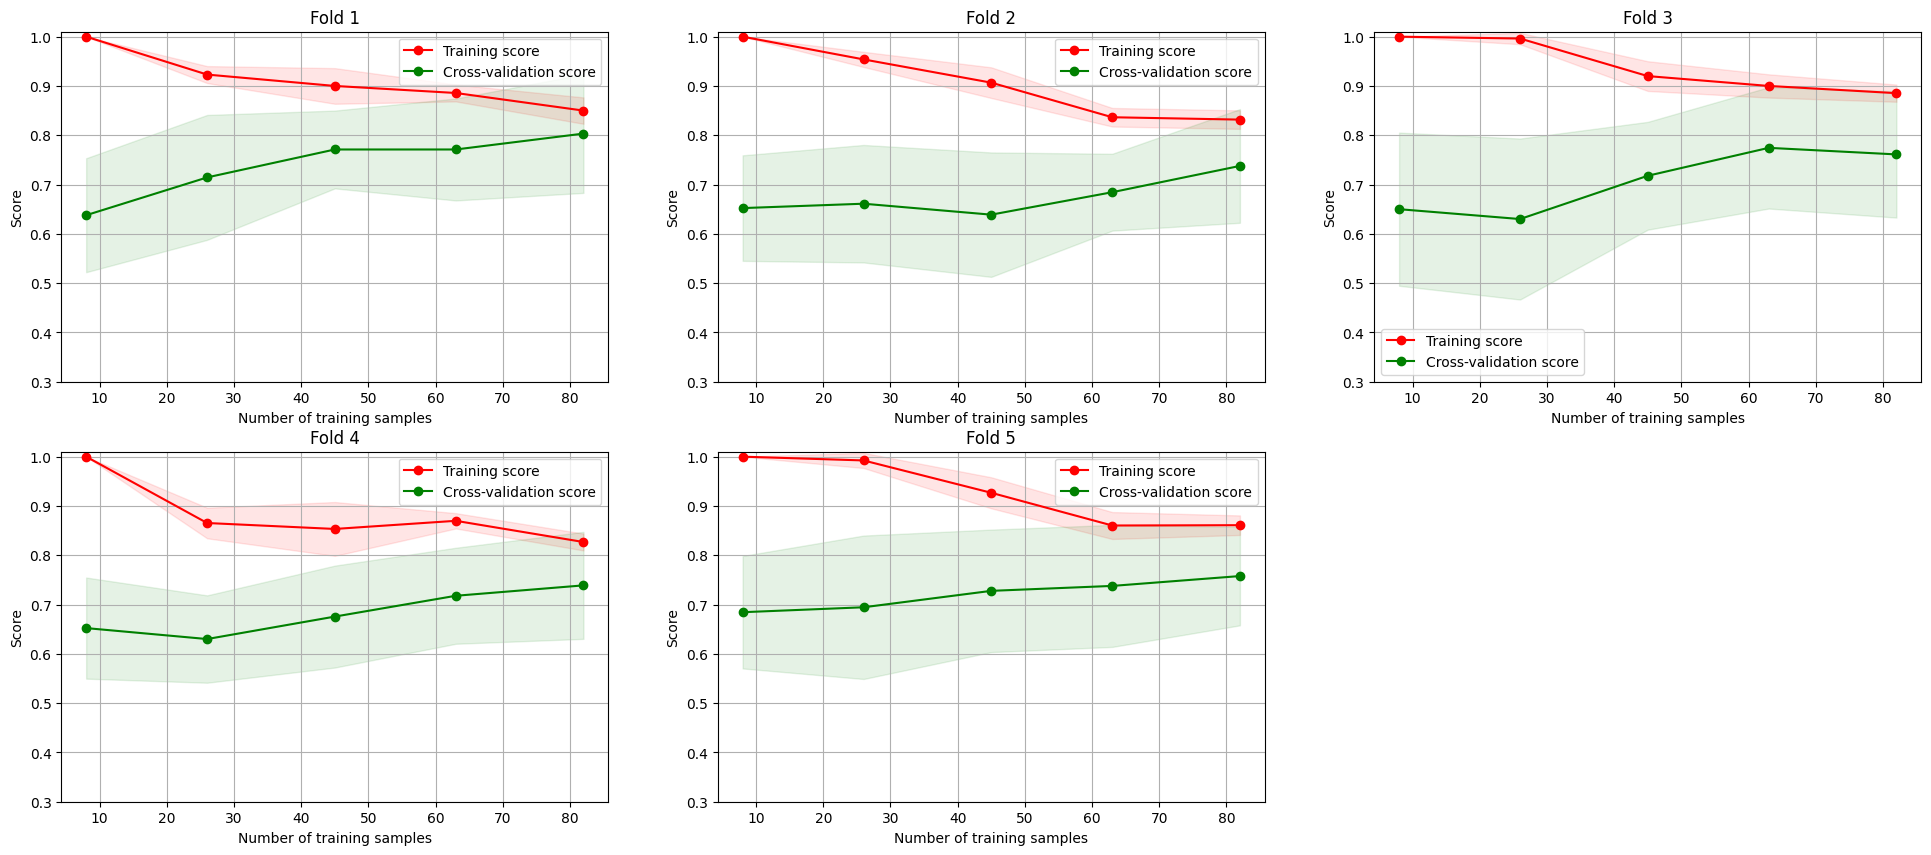

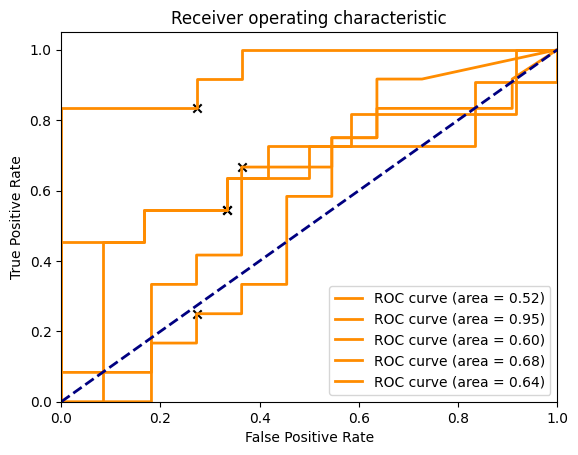

In [60]:
warnings.filterwarnings("ignore")

# Load data
data = load_data()
X, y = extract_labels(data)

# Custom scorer
scoring = {'harmonic_mean': make_scorer(custom_score), 'accuracy': make_scorer(accuracy_score), 'recall': make_scorer(macro_recall)}

# Define split
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initiate classifications
clsfs = list()

harmonic_tot = 0
accuracy_tot = 0
recall_tot = 0

# Loop
fig = plt.figure(figsize=(24,10))
plt.figure()

fold = 0
for train, test in skf.split(X,y):
    # Kondig aan bij welke fold we zijn
    fold += 1
    print("-----------------------------------------")
    print(f"Working on fold ", fold)

    # Splits de data
    X_train = X.iloc[train,:]
    X_test = X.iloc[test,:]
    y_train = y[train]
    y_test = y[test]

    # Pre-processing
    print("Pre-processing")
    X_train, zero_variance, feature_del, scaler, rslt_df, pca, component = pre_processing_train(X_train)

    # Classifier
    clsfs = SVM(X_train,y_train,clsfs)
    clf = clsfs[fold-1]

    # Plotting the learning curve
    ax = fig.add_subplot(2, 3, fold)
    title = str(f"Fold {fold}")
    plot_learning_curve(clf, title, X_train, y_train, ax, ylim=(0.3, 1.01), cv=10)

    # Start test
    print("Now we test it on the test data")
    X_test = pre_processing_test(X_test, zero_variance, feature_del, scaler, rslt_df, pca, component)
    y_score = clf.predict_proba(X_test)

    # Plotting the ROC curves
    plot_roc_curve(y_score, y_test, plt)

    # Scores berekenen
    y_true = y_test
    y_pred = clf.predict(X_test)
    harmonic = custom_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    recall = macro_recall(y_true, y_pred)
    print(f"The accuracy is {accuracy}. The recall is {recall}. The harmonic mean of the two is {harmonic}.")

    harmonic_tot += harmonic
    accuracy_tot += accuracy
    recall_tot += recall

# Gemiddeldes uitrekenen
harmonic_gem = harmonic_tot / fold
accuracy_gem = accuracy_tot / fold
recall_gem = recall_tot / fold
print(f"The average accuracy is {accuracy_gem}. The average recall is {recall_gem}. The average harmonic mean of the two is {harmonic_gem}.")

# Finishing the ROC plot
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()